<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

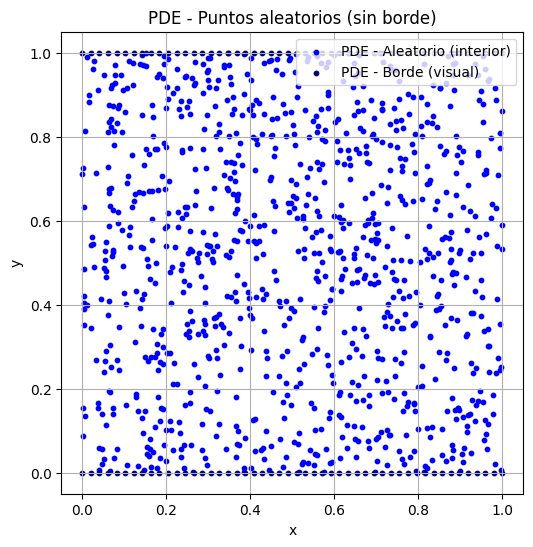

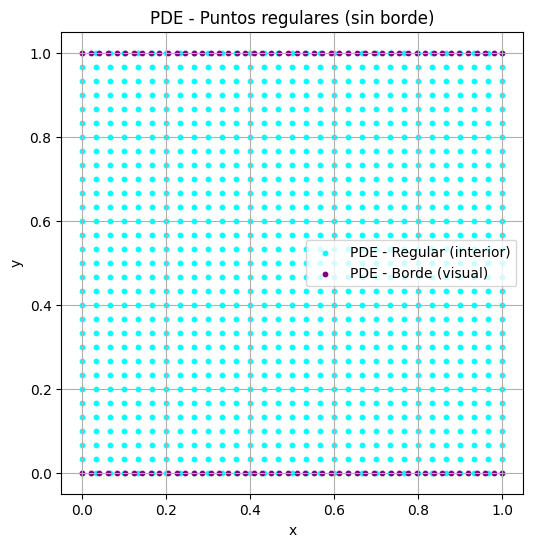

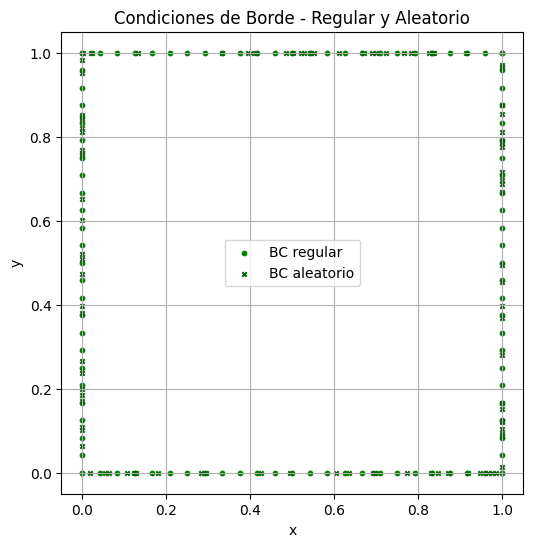

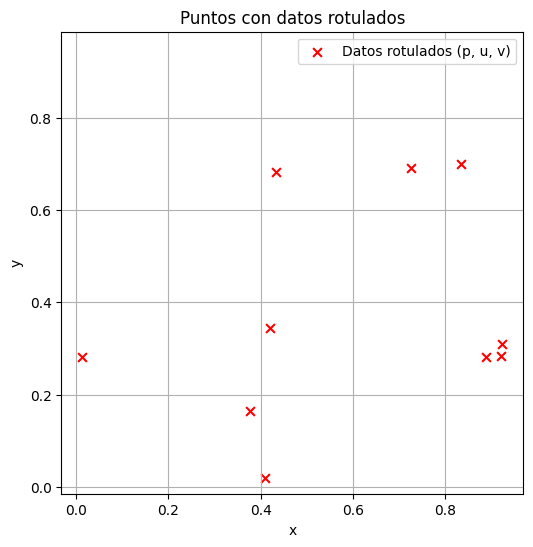


Valores interpolados en puntos rotulados:
     x      y          p          u          v
 0.834  0.700    -0.0617    -0.0736     0.1810
 0.921  0.284    -0.0752    -0.0655     0.2437
 0.888  0.282    -0.0585     0.0055     0.1977
 0.376  0.165    -0.0531    -0.0354     0.2368
 0.409  0.019     0.0021     0.0101    -0.3135
 0.419  0.344     0.0551    -0.0081    -0.3938
 0.432  0.682    -0.0748     0.2482     0.0799
 0.013  0.281     0.0071    -0.0095    -0.0005
 0.726  0.690    -0.0228    -0.2243    -0.0121
 0.924  0.309    -0.0855     0.2402     0.0570


In [1]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Cargar datos
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# Parámetro pequeño para evitar bordes en PDE
eps = 1e-5

# Cantidades de puntos
Npde = 1000
Nbc = 100
Ndata = 10
Nbc_per_edge = Nbc // 4

# --- 1. PUNTOS DE COLOCACIÓN PARA PDE ---

x_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)
y_pde_rand = np.random.uniform(0.0 + eps, 1.0 - eps, Npde)

n_side = int(np.sqrt(Npde))
x_grid = np.linspace(eps, 1.0 - eps, n_side)
y_grid = np.linspace(eps, 1.0 - eps, n_side)
x_pde_reg, y_pde_reg = np.meshgrid(x_grid, y_grid)
x_pde_reg = x_pde_reg.flatten()
y_pde_reg = y_pde_reg.flatten()

N_border = 50
x_pde_border = np.linspace(0, 1, N_border)
y_pde_border_top = np.ones(N_border) * 1.0
y_pde_border_bottom = np.zeros(N_border)
x_pde_border_combined = np.concatenate([x_pde_border, x_pde_border])
y_pde_border_combined = np.concatenate([y_pde_border_bottom, y_pde_border_top])

# --- 2. PUNTOS DE COLOCACIÓN PARA BC ---

x_bc_top_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_top_reg = np.ones_like(x_bc_top_reg)
x_bc_bottom_reg = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom_reg = np.zeros_like(x_bc_bottom_reg)
y_bc_left_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_left_reg = np.zeros_like(y_bc_left_reg)
y_bc_right_reg = np.linspace(0, 1, Nbc_per_edge)
x_bc_right_reg = np.ones_like(y_bc_right_reg)

x_bc_top_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_top_rand = np.ones_like(x_bc_top_rand)
x_bc_bottom_rand = np.random.uniform(0, 1, Nbc_per_edge)
y_bc_bottom_rand = np.zeros_like(x_bc_bottom_rand)
y_bc_left_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_left_rand = np.zeros_like(y_bc_left_rand)
y_bc_right_rand = np.random.uniform(0, 1, Nbc_per_edge)
x_bc_right_rand = np.ones_like(y_bc_right_rand)

# --- 3. PUNTOS ROTULADOS (mediciones) ---

x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)
    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]
    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[min(y_idx, field.shape[0]-1), min(x_idx, field.shape[1]-1)]
    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]
    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# --- GRÁFICAS ---

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_rand, y_pde_rand, s=10, c='blue', label='PDE - Aleatorio (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='navy', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos aleatorios (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_pde_reg, y_pde_reg, s=10, c='cyan', label='PDE - Regular (interior)')
plt.scatter(x_pde_border_combined, y_pde_border_combined, s=10, c='purple', label='PDE - Borde (visual)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('PDE - Puntos regulares (sin borde)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(np.concatenate([x_bc_top_reg, x_bc_bottom_reg, x_bc_left_reg, x_bc_right_reg]),
            np.concatenate([y_bc_top_reg, y_bc_bottom_reg, y_bc_left_reg, y_bc_right_reg]),
            s=10, c='green', label='BC regular')
plt.scatter(np.concatenate([x_bc_top_rand, x_bc_bottom_rand, x_bc_left_rand, x_bc_right_rand]),
            np.concatenate([y_bc_top_rand, y_bc_bottom_rand, y_bc_left_rand, y_bc_right_rand]),
            s=10, c='darkgreen', marker='x', label='BC aleatorio')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Condiciones de Borde - Regular y Aleatorio')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=40, c='red', marker='x', label='Datos rotulados (p, u, v)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos con datos rotulados')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

print("\nValores interpolados en puntos rotulados:")
print(f"{'x':>6} {'y':>6} {'p':>10} {'u':>10} {'v':>10}")
for x, y, p_val, u_val, v_val in zip(x_data, y_data, p_data, u_data, v_data):
    print(f"{x:6.3f} {y:6.3f} {p_val:10.4f} {u_val:10.4f} {v_val:10.4f}")



Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.

#TP2


Ep 1000: mom=1.22e-02, cont=4.95e-02, BC=4.20e-02, P0=1.62e-08
Ep 2000: mom=1.04e-02, cont=2.81e-02, BC=3.08e-02, P0=7.86e-09
Ep 3000: mom=6.44e-03, cont=1.40e-02, BC=2.03e-02, P0=3.88e-06
Ep 4000: mom=1.01e-02, cont=8.01e-03, BC=1.53e-02, P0=5.51e-07
Ep 5000: mom=1.36e-02, cont=6.77e-03, BC=1.31e-02, P0=4.90e-07
Ep 6000: mom=1.28e-02, cont=5.91e-03, BC=1.29e-02, P0=2.08e-01
Ep 7000: mom=1.63e-02, cont=5.81e-03, BC=1.15e-02, P0=3.29e-09
Ep 8000: mom=1.62e-02, cont=6.01e-03, BC=1.12e-02, P0=2.04e-05
Ep 9000: mom=1.62e-02, cont=6.36e-03, BC=1.08e-02, P0=1.72e-07
Ep 10000: mom=1.72e-02, cont=6.74e-03, BC=1.05e-02, P0=4.50e-09


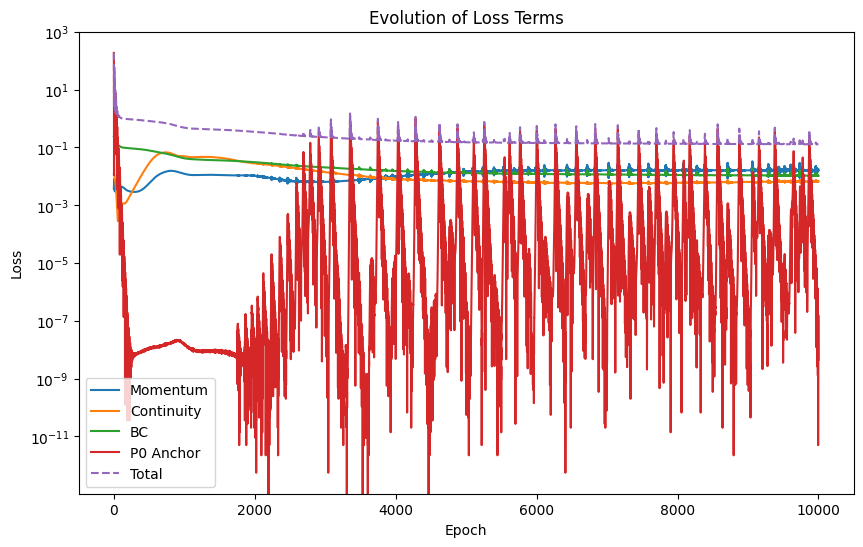

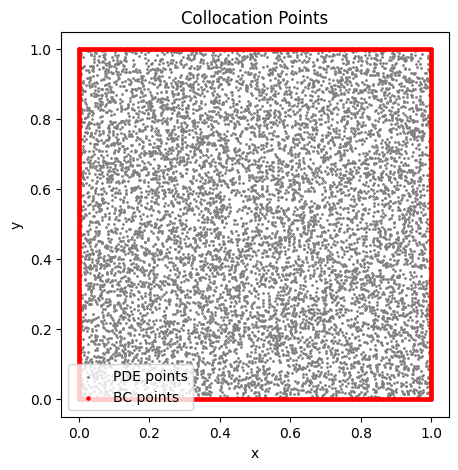

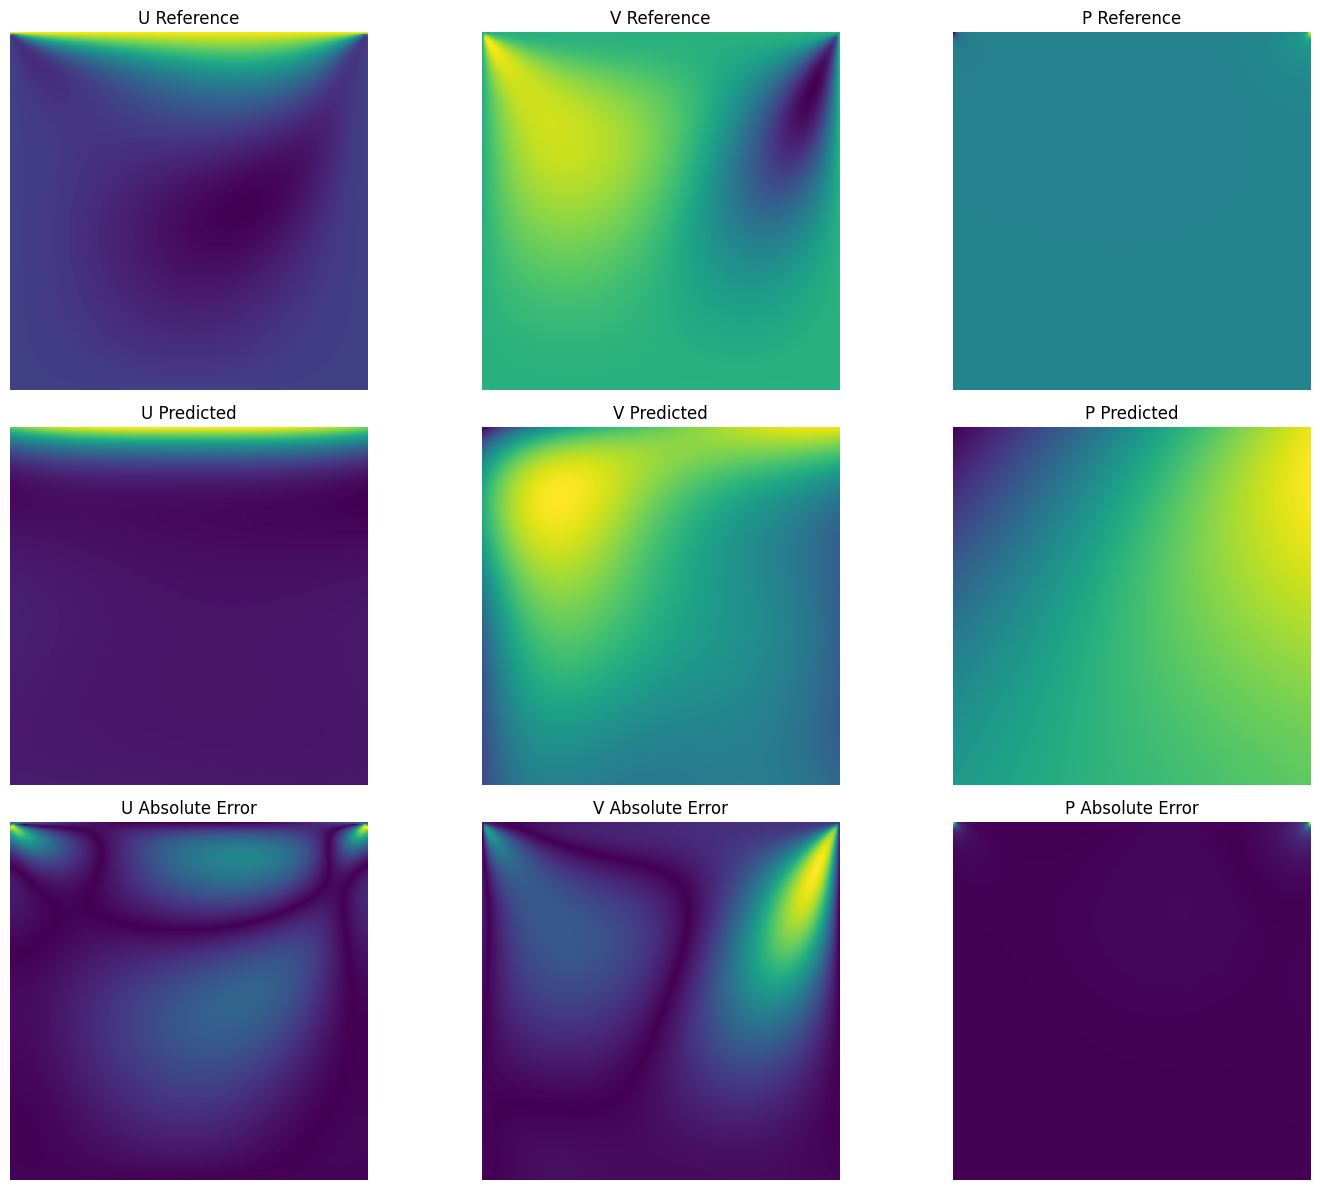

| Variable | L2 Relative Error |
|----------|------------------:|
| u        | 0.5099           |
| v        | 0.9601           |
| p        | 0.9711           |


In [8]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import griddata
import torch
import torch.nn as nn
from torch.autograd import grad
from scipy.stats import qmc

# --- TP2 PINN vanilla con gráficas y análisis completos ---
# Arquitectura y hiperparámetros:
#   - Red: FC 4 capas de 50 neuronas, activación Tanh
#   - Re = 100, λ_bc = 10, anchor presión = 1e4
#   - Adam lr=1e-3, epochs=10000

# Dispositivo y parámetros
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Re        = 100.0
lambda_bc = 10.0
lambda_p0 = 1e4
Npde, Nbc = 10000, 1000
epochs    = 10000
lr        = 1e-3

# 1. Carga de datos y coordenadas originales
dm    = loadmat('velocity.mat')
x_pts = dm['x'].squeeze()
y_pts = dm['y'].squeeze()
u_pts = dm['u'].squeeze()
v_pts = dm['v'].squeeze()
p_pts = loadmat('pressure.mat')['p'].squeeze()

# 2. Malla regular para interpolación y plots
x_unique = np.linspace(x_pts.min(), x_pts.max(), 201)
y_unique = np.linspace(y_pts.min(), y_pts.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)
U_grid = griddata((x_pts, y_pts), u_pts, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x_pts, y_pts), v_pts, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x_pts, y_pts), p_pts, (X_grid, Y_grid), method='cubic')

# 3. Definición de la PINN
def make_PINN():
    return nn.Sequential(
        nn.Linear(2, 50), nn.Tanh(),
        nn.Linear(50, 50), nn.Tanh(),
        nn.Linear(50, 50), nn.Tanh(),
        nn.Linear(50, 3)
    )
model = make_PINN().to(device)

# 4. Residuos (momento y continuidad)
def residuals(xy):
    uvp = model(xy)
    u, v, p = uvp[:,0:1], uvp[:,1:2], uvp[:,2:3]
    def grads(f):
        return grad(f, xy, grad_outputs=torch.ones_like(f), create_graph=True)[0]
    u_x, u_y = grads(u).split(1,1)
    v_x, v_y = grads(v).split(1,1)
    p_x, p_y = grads(p).split(1,1)
    u_xx = grads(u_x).split(1,1)[0]; u_yy = grads(u_y).split(1,1)[1]
    v_xx = grads(v_x).split(1,1)[0]; v_yy = grads(v_y).split(1,1)[1]
    res_x = u*u_x + v*u_y + p_x - (1/Re)*(u_xx + u_yy)
    res_y = u*v_x + v*v_y + p_y - (1/Re)*(v_xx + v_yy)
    cont  = u_x + v_y
    return res_x, res_y, cont

# 5. Muestreo de collocation y condiciones de contorno
torch.manual_seed(0)
xy_pde = torch.rand(Npde, 2, device=device, requires_grad=True)

def sample_bc(N):
    per = N // 4
    xs = torch.linspace(0,1,per, device=device)
    b  = torch.stack([xs, torch.zeros_like(xs)],1)
    t  = torch.stack([xs, torch.ones_like(xs)],1)
    ys = xs.clone()
    l  = torch.stack([torch.zeros_like(ys), ys],1)
    r  = torch.stack([torch.ones_like(ys), ys],1)
    return torch.cat([b, t, l, r],0)[:N]
xy_bc   = sample_bc(Nbc)
ubc     = torch.zeros(Nbc,1, device=device)
vbc     = torch.zeros_like(ubc)
mask    = xy_bc[:,1] == 1.0
ubc[mask,0] = 1.0

# 6. Anclaje de presión en (0,0)
xy_p0     = torch.tensor([[0.0,0.0]], device=device)
p0_target = torch.tensor([[0.0]], device=device)

# 7. Definición del optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Inicializar listas para seguimiento de pérdidas
loss_mom_list, loss_cont_list = [], []
loss_bc_list, loss_p0_list, loss_tot_list = [], [], []

# 8. Bucle de entrenamiento
for ep in range(1, epochs+1):
    optimizer.zero_grad()
    rx, ry, rc = residuals(xy_pde)
    loss_mom  = (rx**2 + ry**2).mean()
    loss_cont = (rc**2).mean()
    uvb       = model(xy_bc)
    loss_bc   = ((uvb[:,0:1] - ubc)**2 + (uvb[:,1:2] - vbc)**2).mean()
    p0_pred   = model(xy_p0)[:,2:3]
    loss_p0   = lambda_p0 * (p0_pred - p0_target).pow(2).mean()
    loss_total = loss_mom + loss_cont + lambda_bc * loss_bc + loss_p0
    loss_total.backward()
    optimizer.step()

    # Guardar pérdidas
    loss_mom_list.append(loss_mom.item())
    loss_cont_list.append(loss_cont.item())
    loss_bc_list.append(loss_bc.item())
    loss_p0_list.append(loss_p0.item())
    loss_tot_list.append(loss_total.item())

    if ep % 1000 == 0:
        print(f"Ep {ep}: mom={loss_mom:.2e}, cont={loss_cont:.2e}, BC={loss_bc:.2e}, P0={loss_p0:.2e}")

# 9. Evolución de pérdidas
plt.figure(figsize=(10,6))
plt.plot(loss_mom_list, label='Momentum')
plt.plot(loss_cont_list, label='Continuity')
plt.plot(loss_bc_list, label='BC')
plt.plot(loss_p0_list, label='P0 Anchor')
plt.plot(loss_tot_list, label='Total', linestyle='--')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.title('Evolution of Loss Terms'); plt.show()

# 10. Scatter de puntos PDE vs BC
plt.figure(figsize=(5,5))
xy_pde_np = xy_pde.detach().cpu().numpy()
xy_bc_np  = xy_bc.detach().cpu().numpy()
plt.scatter(xy_pde_np[:,0], xy_pde_np[:,1], s=1, c='gray', label='PDE points')
plt.scatter(xy_bc_np[:,0], xy_bc_np[:,1], s=5, c='red', label='BC points')
plt.xlabel('x'); plt.ylabel('y'); plt.legend(); plt.title('Collocation Points'); plt.show()

# 11. Evaluación en grilla y mapas de error
pts = torch.tensor(np.vstack([X_grid.ravel(), Y_grid.ravel()]).T,
                   dtype=torch.float32, device=device)
with torch.no_grad():
    pred_uvp = model(pts).cpu().numpy()
U_pred = pred_uvp[:,0].reshape(X_grid.shape)
V_pred = pred_uvp[:,1].reshape(X_grid.shape)
P_pred = pred_uvp[:,2].reshape(X_grid.shape)

fig, axs = plt.subplots(3,3, figsize=(15,12))
for i,(ref,pred,title) in enumerate(zip([U_grid, V_grid, P_grid],
                                       [U_pred, V_pred, P_pred],
                                       ['U','V','P'])):
    axs[0,i].imshow(ref, origin='lower', extent=[x_pts.min(), x_pts.max(), y_pts.min(), y_pts.max()])
    axs[0,i].set_title(f'{title} Reference')
    axs[1,i].imshow(pred, origin='lower', extent=[x_pts.min(), x_pts.max(), y_pts.min(), y_pts.max()])
    axs[1,i].set_title(f'{title} Predicted')
    axs[2,i].imshow(np.abs(pred-ref), origin='lower', extent=[x_pts.min(), x_pts.max(), y_pts.min(), y_pts.max()])
    axs[2,i].set_title(f'{title} Absolute Error')
    for ax in axs[:,i]: ax.axis('off')
plt.tight_layout(); plt.show()

# 12. Tabla de errores L2 relativos
mask = ~np.isnan(U_grid)
err_u = np.linalg.norm(U_pred[mask]-U_grid[mask]) / np.linalg.norm(U_grid[mask])
mask = ~np.isnan(V_grid)
err_v = np.linalg.norm(V_pred[mask]-V_grid[mask]) / np.linalg.norm(V_grid[mask])
mask = ~np.isnan(P_grid)
err_p = np.linalg.norm(P_pred[mask]-P_grid[mask]) / np.linalg.norm(P_grid[mask])
print('| Variable | L2 Relative Error |')
print('|----------|------------------:|')
print(f"| u        | {err_u:.4f}           |")
print(f"| v        | {err_v:.4f}           |")
print(f"| p        | {err_p:.4f}           |")



## PUNTO 5
